# San Francisco Bike Trips
This notebook contains an exploratory data analysis of a publicly available dataset from Google Bigquery (https://console.cloud.google.com/marketplace/details/san-francisco-public-data/sf-bike-share).

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

In [2]:
keyfile = r'C:\Users\chung\Desktop\code_portfolio\analytics\_creds\bq-public.json'
credentials = service_account.Credentials.from_service_account_file(
    keyfile,
    scopes=['https://www.googleapis.com/auth/cloud-platform']
)

In [3]:
client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id
)

# API Call & Initial Data Cleansing

Viewing the sample data from the console, it appears that the ***bikeshare_trips*** table is the dataset of interest. The lat/lon coordinates are missing for many rows, so that can be obtained for most of the missing data by joining to the ***bikeshare_station_info*** table. Even then there are still some missing station id's. One approach could be to use the Google Maps API, but for the purposes of this analysis, the missing 20 stations were just manually looked up and saved to a local csv.

In [4]:
# trips query
sql_str = """
    SELECT
        t.start_station_name,
        t.start_station_id,
        t.end_station_name,
        t.end_station_id,
        s1.lat AS start_latitude,
        s1.lon AS start_longitude,
        s2.lat AS end_latitude,
        s2.lon AS end_longitude,
        COUNT(*) AS trips 
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` AS t

    LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` AS s1
        ON t.start_station_id = s1.station_id

    LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` AS s2
        ON t.end_station_id = s2.station_id

    GROUP BY
        t.start_station_name,
        t.start_station_id,
        t.end_station_name,
        t.end_station_id,
        s1.lat,
        s1.lon,
        s2.lat,
        s2.lon

    ORDER BY
        COUNT(*) DESC
"""

def fetch_bq(client, sql_str):
    df = client.query(sql_str).to_dataframe()
    return df


df_trips = fetch_bq(client, sql_str)
df_trips.head(20)

,start_station_name,start_station_id,end_station_name,end_station_id,start_latitude,start_longitude,end_latitude,end_longitude,trips
0,Harry Bridges Plaza (Ferry Building),50,Embarcadero at Sansome,60,37.780526,-122.390288,37.774520,-122.409449,9150
1,San Francisco Caltrain 2 (330 Townsend),69,Townsend at 7th,65,NaN,NaN,NaN,NaN,8508
2,2nd at Townsend,61,Harry Bridges Plaza (Ferry Building),50,37.776513,-122.411306,37.780526,-122.390288,7620
3,Harry Bridges Plaza (Ferry Building),50,2nd at Townsend,61,37.780526,-122.390288,37.776513,-122.411306,6888
4,Embarcadero at Sansome,60,Steuart at Market,74,37.774520,-122.409449,37.776435,-122.426244,6874
5,Townsend at 7th,65,San Francisco Caltrain 2 (330 Townsend),69,NaN,NaN,NaN,NaN,6836
6,Embarcadero at Folsom,51,San Francisco Caltrain (Townsend at 4th),70,37.776101,-122.453093,37.773311,-122.444293,6351
7,San Francisco Caltrain (Townsend at 4th),70,Harry Bridges Plaza (Ferry Building),50,37.773311,-122.444293,37.780526,-122.390288,6215
8,Steuart at Market,74,2nd at Townsend,61,37.776435,-122.426244,37.776513,-122.411306,6039
9,Steuart at Market,74,San Francisco Caltrain (Townsend at 4th),70,37.776435,-122.426244,37.773311,-122.444293,5959


Viewing the data, there are still missing lats/lons which will be handled through a local file. There are only 20 station id's that have missing data so these have been manually researched.

In [30]:
# get missing station data from local file
f_path = r'C:\Users\chung\Desktop\code_portfolio\analytics\sf-bikeshare\missing_stations.csv'
df_miss = pd.read_csv(f_path)

# fill in missing data in df_trips
def fill_missing(df, df_miss, start_or_end):
    df = pd.merge(df, df_miss, how='left', left_on=f'{start_or_end}_station_id',
                        right_on='station_id')
    df.loc[df[f'{start_or_end}_latitude'].isnull(),
                f'{start_or_end}_latitude'] = df['lat']
    df.loc[df[f'{start_or_end}_longitude'].isnull(),
                f'{start_or_end}_longitude'] = df['lon']
    df.drop(['station_id', 'station_name', 'lat', 'lon'], axis=1, inplace=True)
    
    return df

df_trips = fill_missing(df_trips, df_miss, 'start')
df_trips = fill_missing(df_trips, df_miss, 'end')
df_trips.head(20)

,start_station_name,start_station_id,end_station_name,end_station_id,start_latitude,start_longitude,end_latitude,end_longitude,trips,start-end,distance
0,Harry Bridges Plaza (Ferry Building),50,Embarcadero at Sansome,60,37.780526,-122.390288,37.774520,-122.409449,9150,Harry Bridges Plaza (Ferry Building)|Embarcade...,1.342478
1,San Francisco Caltrain 2 (330 Townsend),69,Townsend at 7th,65,37.776900,-122.394907,37.772034,-122.401587,8508,San Francisco Caltrain 2 (330 Townsend)|Townse...,0.495458
2,2nd at Townsend,61,Harry Bridges Plaza (Ferry Building),50,37.776513,-122.411306,37.780526,-122.390288,7620,2nd at Townsend|Harry Bridges Plaza (Ferry Bui...,1.459808
3,Harry Bridges Plaza (Ferry Building),50,2nd at Townsend,61,37.780526,-122.390288,37.776513,-122.411306,6888,Harry Bridges Plaza (Ferry Building)|2nd at To...,1.459808
4,Embarcadero at Sansome,60,Steuart at Market,74,37.774520,-122.409449,37.776435,-122.426244,6874,Embarcadero at Sansome|Steuart at Market,1.162576
5,Townsend at 7th,65,San Francisco Caltrain 2 (330 Townsend),69,37.772034,-122.401587,37.776900,-122.394907,6836,Townsend at 7th|San Francisco Caltrain 2 (330 ...,0.495458
6,Embarcadero at Folsom,51,San Francisco Caltrain (Townsend at 4th),70,37.776101,-122.453093,37.773311,-122.444293,6351,Embarcadero at Folsom|San Francisco Caltrain (...,0.616785
7,San Francisco Caltrain (Townsend at 4th),70,Harry Bridges Plaza (Ferry Building),50,37.773311,-122.444293,37.780526,-122.390288,6215,San Francisco Caltrain (Townsend at 4th)|Harry...,3.740957
8,Steuart at Market,74,2nd at Townsend,61,37.776435,-122.426244,37.776513,-122.411306,6039,Steuart at Market|2nd at Townsend,1.032126
9,Steuart at Market,74,San Francisco Caltrain (Townsend at 4th),70,37.776435,-122.426244,37.773311,-122.444293,5959,Steuart at Market|San Francisco Caltrain (Town...,1.252413


In [6]:
df_trips.shape

(27155, 9)

# Analysis

**Which routes are most popular?**

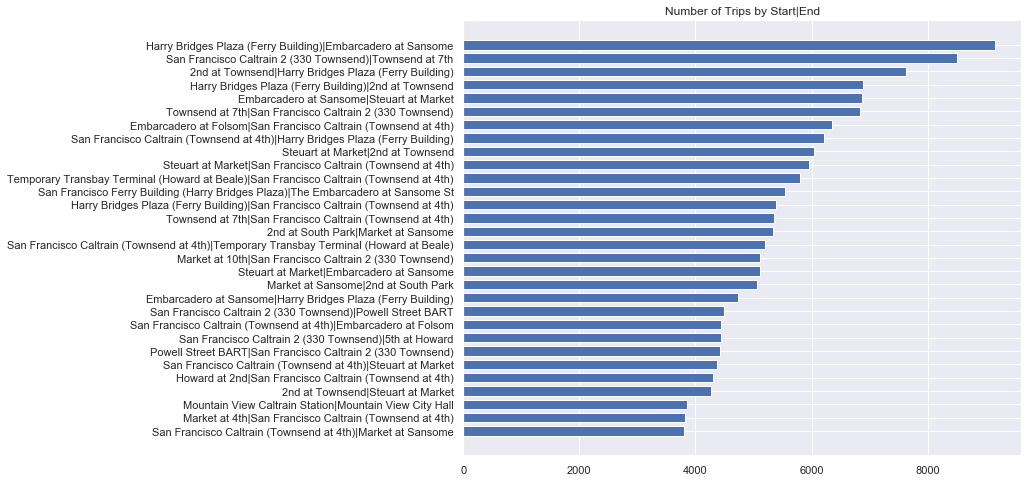

In [28]:
# plot top 30 start-end pairs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

def bar_plot():
    df_trips['start-end'] = df_trips['start_station_name'] + '|' + df_trips['end_station_name']
    bar_labels = list(df_trips.loc[:29, 'start-end'])
    y_pos = list(reversed(np.arange(len(bar_labels))))
    bar_vals = list(df_trips.loc[:29, 'trips'])

    plt.figure(figsize=(10,8))
    plt.barh(y_pos, bar_vals, height=0.7)
    plt.yticks(y_pos, bar_labels)
    plt.title('Number of Trips by Start|End')

    plt.show()

bar_plot()

In the bar plot, the y-axis contains the start station name and end station name separated by a pipe.

Not surprisingly there are the most trips near large tourist areas or transit hubs. These trips have distances that are a bit too far to walk but too short/inconvenient to take a bus/car. Other factors influencing these counts might be parking costs vs. bicycle costs, rideshare costs, percentage of tourists vs. normal inhabitants visiting the area, etc.

**What is the average trip time?** This can be answered with a short query.

In [8]:
sql_str = """
    SELECT AVG(duration_sec) AS seconds
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
"""

result = fetch_bq(client, sql_str)
print(result)

       seconds
0  1007.971298


**What is the average distance?**

By using the start and end lat/lon coordinates, the distance for each trip can be calculated. The **haversine formula** can be used to calculate the distance between two points on a sphere. Although the earth is not a perfect sphere, it will be a good approximation especially since the distances are miniscule relative to the earth's size.

In order to have a more complete dataset, the local csv mentioned previously will be used to fill in the missing lats/lons.

In [9]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    miles = 3958.8 * c    # radius of earth in miles
    
    return miles

df_trips['distance'] = haversine(df_trips['start_latitude'],
                                df_trips['start_longitude'],
                                df_trips['end_latitude'],
                                df_trips['end_longitude'])

avg_dist = (df_trips['trips'] * df_trips['distance']).sum() / df_trips['trips'].sum()

print(f'Average Trip Distance: {round(avg_dist,4)} miles')

Average Trip Distance: 1.3536 miles


The average trip distance of 1.35 miles makes sense. People will want to use bicycles for transport if the trip is a bit too short for taking a car/bus/train but too long for walking.

**Plot a heatmap**

Determine via a heatmap if there are any patterns to trip frequency between the start and end station pairs. The stations will be ordered from northwest to southeast. Also, because most stations have no activity to most other stations, the heatmap will be zoomed into San Francisco stations since these stations will have more activity than others. 

True


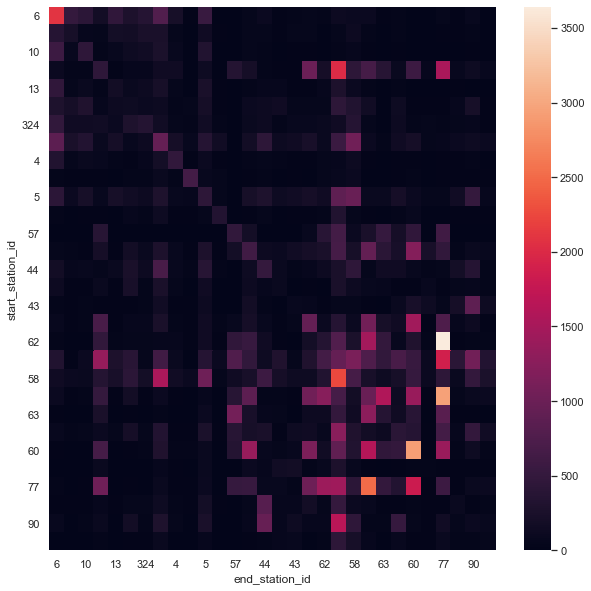

In [10]:
# see if there are the same number of start stations as end stations
start_uniq = list(df_trips['start_station_id'].unique())
end_uniq = list(df_trips['end_station_id'].unique())
check = all(item in start_uniq for item in end_uniq)
print(check)

# most stations don't have much activity to most other stations. focus the heatmap where there is more activity.
# drop rows with lat/lon that are far away from city center
def make_df_sub(df_trips):
    df_sub = df_trips.loc[(df_trips['start_latitude']>37.77) &
                        (df_trips['start_longitude']>-122.42) &
                        (df_trips['start_latitude']<37.807752) &
                        (df_trips['start_longitude']<-122.402) &
                        (df_trips['end_latitude']>37.77) &
                        (df_trips['end_longitude']>-122.42) &
                        (df_trips['end_latitude']<37.807752) &
                        (df_trips['end_longitude']<-122.402)
    ]

    return df_sub


# order the station id's from northwest to southeast
def order_ids(df_sub):
    df_id = pd.DataFrame(df_sub, columns=['start_station_id',
                                            'start_latitude',
                                            'start_longitude'])
    df_id = df_id.drop_duplicates()
    df_id.columns = ['id','lat','lon']
    df_id = df_id.sort_values(['lat','lon'], ascending=[False, True])
    order = list(df_id['id'].values)

    return order


# create new df for heatmap
def make_heat_df(df_sub, order):  
    df_heat = pd.crosstab(df_sub['start_station_id'],df_sub['end_station_id'],
                            values=df_sub['trips'],aggfunc='sum')
    df_heat = df_heat.fillna(0)

    df_heat = df_heat.reindex(order, axis=0)
    df_heat = df_heat.reindex(order, axis=1)

    return df_heat


# create heatmap
df_sub = make_df_sub(df_trips)
order = order_ids(df_sub)
df_heat = make_heat_df(df_sub, order)
ax = sns.heatmap(df_heat)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

The above dataset has been limited to the northeast section of San Francisco where there are a number of bike stations. The heatmap data is sorted with upper-left corresponding to most northwest, and lower-right corresponding to most southeast, and viewing the heatmap there is generally more activity in the lower-right quadrant of the chart. This roughly matches the higher concentration of bike stations being in the southeast section of the area analyzed.

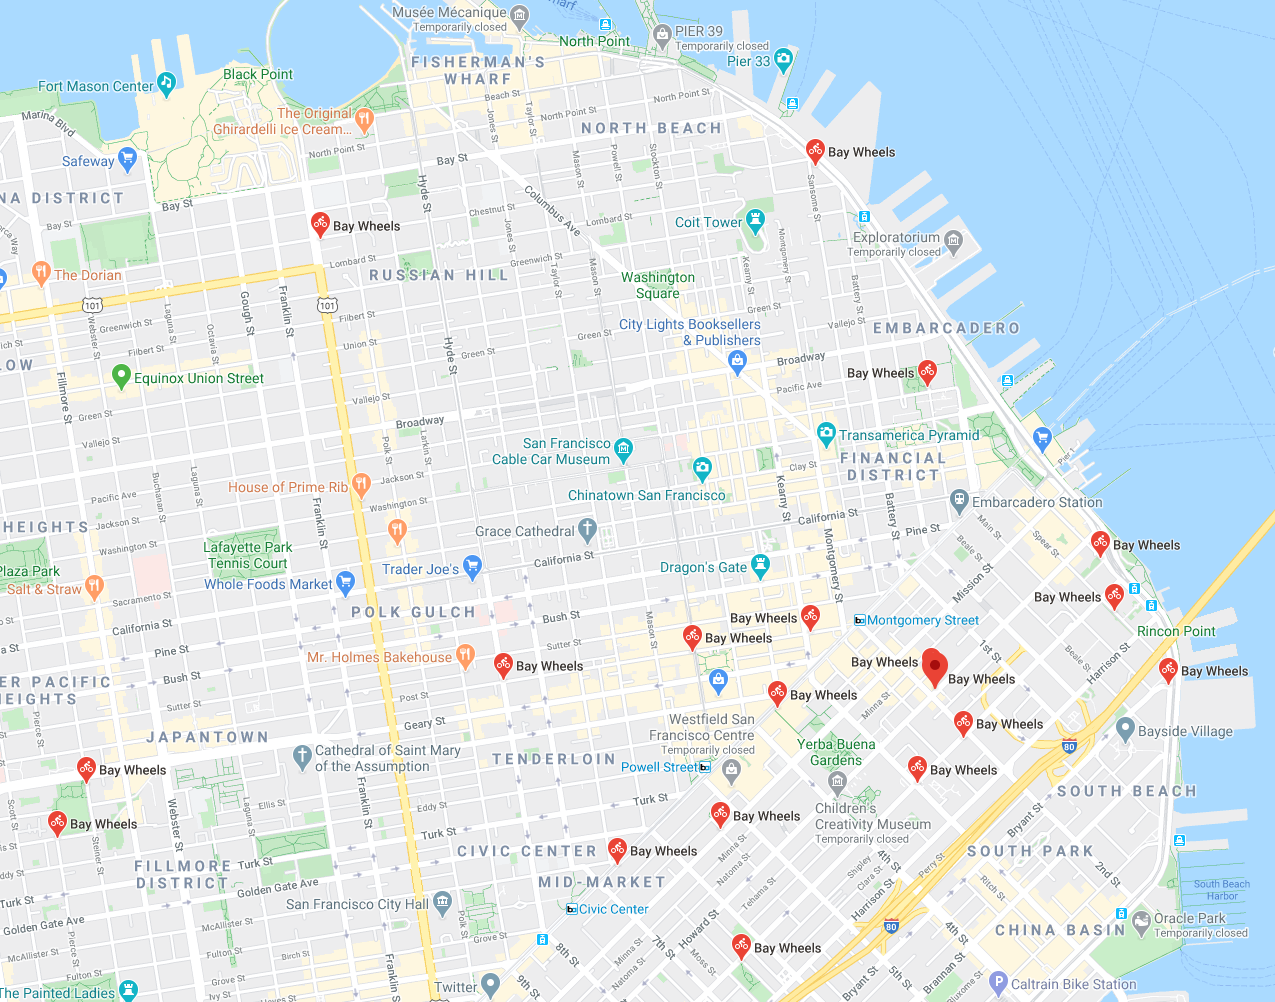

**Plot the stations on a map**

Using the lat/lon combinations of the stations as well as the trip frequency, below is a plot of each station with the size of the points being scaled to the number of trips originating from that location, and the color representing how many bikes are at that location.

In [91]:
# plot stations on a map with size of points scaled to # of trips originating from that location
import folium
import branca

# aggregate trips per starting station
def agg_trips(df_trips):
    df_station_trips = df_trips.pivot_table(values='trips',
                                            index='start_station_id',
                                            aggfunc='sum')
    df_station_trips.reset_index(level=0, inplace=True)

    return df_station_trips


df_station_trips = agg_trips(df_trips)


sql_str = """
    SELECT *
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info`
"""

df_station_info = fetch_bq(client, sql_str)


def transform_stations(df_station_trips, df_station_info):
    # merge df_station_info with df_station_trips
    df_station_info = pd.merge(df_station_info, df_station_trips, how='left',
                                left_on='station_id', right_on='start_station_id')
    df_station_info['trips'] = df_station_info['trips'].fillna(0)

    # drop rows with both trips = 0 and capacity = 0
    df_station_info = df_station_info.loc[~((df_station_info['trips']==0) &
                                            (df_station_info['capacity']==0))]

    # add columns to use for markers
    df_station_info['trips_scaled'] = df_station_info['trips']/2500
    df_station_info.loc[df_station_info['trips_scaled']<5, 'trips_scaled'] = 5

    return df_station_info


df_station_info = transform_stations(df_station_trips, df_station_info)


def map_stations(df_station_info):
    # set up map
    m = folium.Map(
        location=[37.78,-122.44],
        zoom_start=13,
        #tiles='Stamen Toner'
        tiles='CartoDB Positron'
    )

    # colors
    colors = ['#ef8a62','#3182bd','#31a354']

    for i, r in df_station_info.iterrows():
        lat = r['lat']
        lon = r['lon']
        r = r['trips_scaled']
        station = df_station_info.at[i,'name']
        capacity = df_station_info.at[i,'capacity']
        c = colors[capacity//20]
        folium.CircleMarker(location=[lat, lon],
                            radius=r,
                            popup=station,
                            color=c,
                            weight=1,
                            fill_color=c,
                            fill_opacity=0.6).add_to(m)

    colormap = branca.colormap.StepColormap(colors=colors, index=[0,20,40], vmin=0, vmax=45,
                                                caption='Number of Bicycles')
    colormap.add_to(m)

    return m

map_stations(df_station_info)

It appears that a large number of trips originate along a cluster of stations that run horizontally along the map, roughly in the middle of the displayed area. Some of these stations are colored orange, indicating there are less than 20 bikes at those stations. In order to meet the higher demand at those locations, some additional bikes could be relocated or added to those stations.

Viewing the data further on the GCP console, a few more columns of interest could be analyzed. First, the start_date/end_date columns could be used.

**Is there a trend displayed over time?**

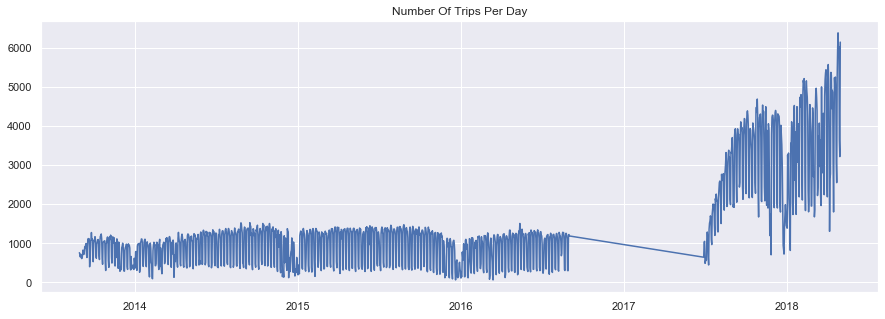

In [25]:
sql_str = """
    SELECT DATE(start_date) AS st_dt, COUNT(*) AS trips
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    GROUP BY st_dt
    ORDER BY st_dt
"""

df_time = fetch_bq(client, sql_str)

plt.figure(figsize=(15,5))
plt.plot(df_time['st_dt'], df_time['trips'])
plt.title('Number Of Trips Per Day')

plt.show()

There's a chunk of data missing from mid 2016 to mid 2017. Nevertheless from mid 2017 through 2018, there was a fairly large increase in bike sharing. The data also appears very bumpy, and there could be various underlying reasons for that (e.g. rainy days). Below is a plot by summing the total for each month.

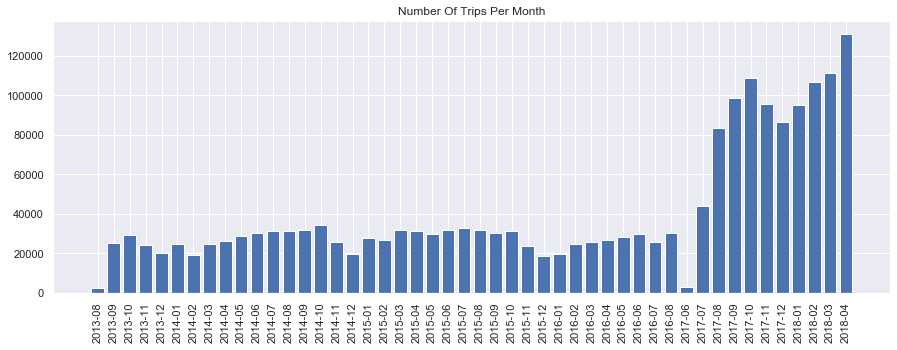

In [24]:
# chart monthly total
df_time['st_dt'] = pd.to_datetime(df_time['st_dt'], format='%Y-%m-%d')
df_time['year'] = df_time['st_dt'].dt.year
df_time['month'] = df_time['st_dt'].dt.month
df_time.loc[df_time['month']<10, 'year-month'] = df_time['year'].astype(str) + '-0' + df_time['month'].astype(str)
df_time.loc[df_time['month']>=10, 'year-month'] = df_time['year'].astype(str) + '-' + df_time['month'].astype(str)
df_monthly = df_time.pivot_table(values='trips',index='year-month', aggfunc='sum')
df_monthly.reset_index(level=0, inplace=True)

plt.figure(figsize=(15,5))
plt.bar(df_monthly['year-month'], df_monthly['trips'])
plt.xticks(rotation=90)
plt.title('Number Of Trips Per Month')

plt.show()

In this plot, the x-axis is converted to a string and no longer has linear scaling (the skipped months disappear). There may be a seasonality trend as in any given year, it appears that winter months have lower volume relative to other months nearby.

**Age and gender distributions**

Text(0.5, 1.0, 'Number of Riders by Gender and Age')

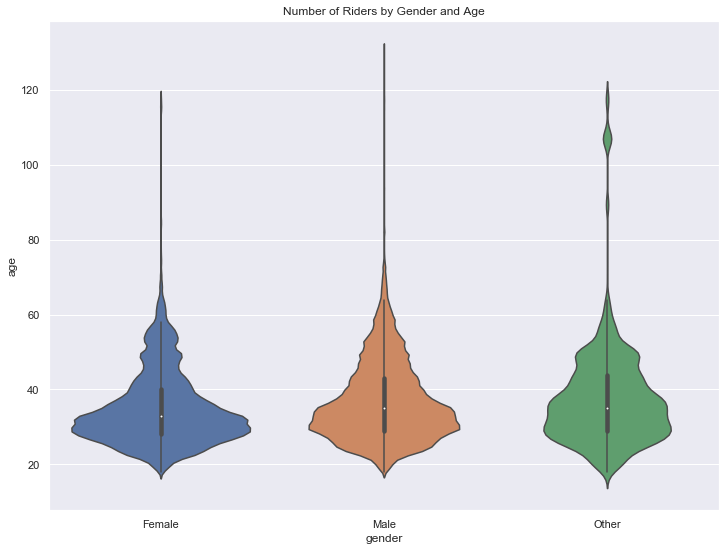

In [20]:
# violin plot across genders
sql_str = """
    SELECT (EXTRACT(YEAR FROM start_date) - member_birth_year) AS age,
        member_gender AS gender
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`

    WHERE start_date IS NOT NULL
    AND member_birth_year IS NOT NULL
    AND member_gender IS NOT NULL
"""

df_members = fetch_bq(client, sql_str)

sns.set(rc={'figure.figsize':(12,9)})
sns.violinplot(x=df_members['gender'], y=df_members['age']).set_title('Number of Riders by Gender and Age')

There are some bad birth years in the dataset since the age extends beyond a reasonable number, and the gender is oftentimes not provided, evidenced by the substantial number of observations for Other. If we combine all data and look at an age distribution:

Text(0.5, 1.0, 'Probability Density by Age')

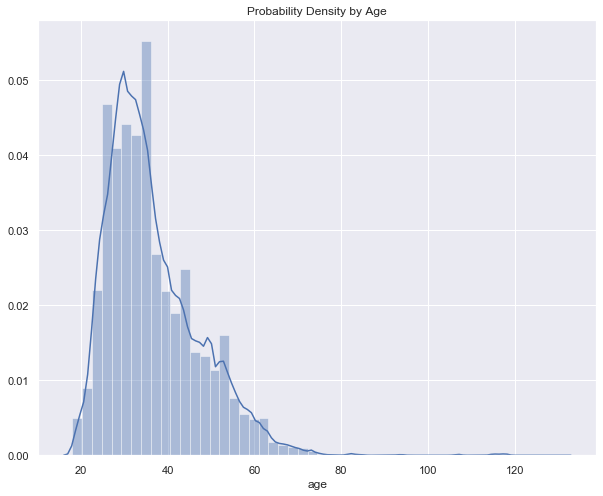

In [21]:
sql_str = """
    SELECT (EXTRACT(YEAR FROM start_date) - member_birth_year) AS age
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE member_birth_year IS NOT NULL
"""

df_members = fetch_bq(client, sql_str)

sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(df_members['age']).set_title('Probability Density by Age')

**Plot lines by subscriber type**

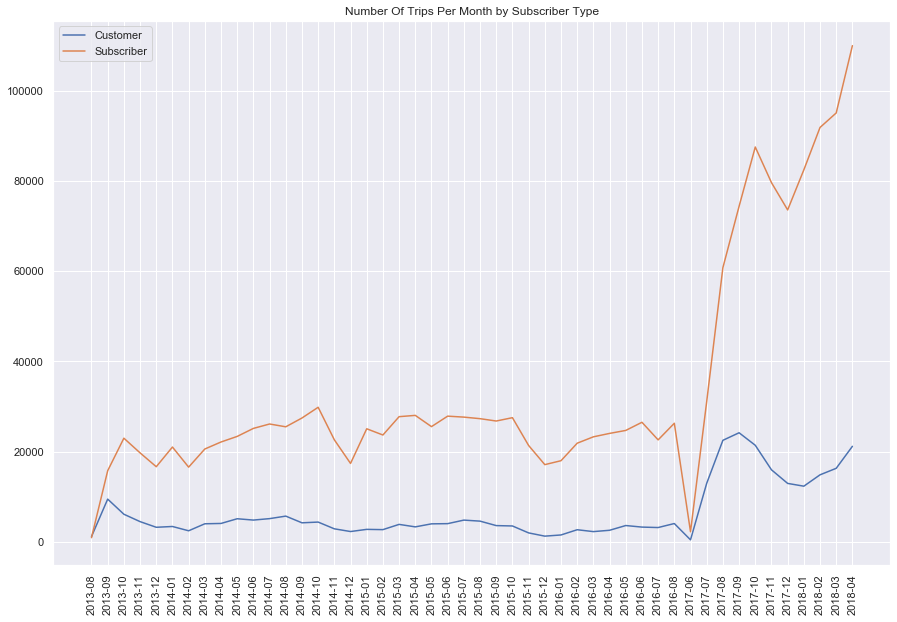

In [27]:
# subscriber type
sql_str = """
    SELECT
        CASE
            WHEN EXTRACT(MONTH FROM start_date) < 10
            THEN CONCAT(EXTRACT(YEAR FROM start_date),'-0',EXTRACT(MONTH FROM start_date))
            ELSE CONCAT(EXTRACT(YEAR FROM start_date),'-',EXTRACT(MONTH FROM start_date))
        END AS year_month,
        subscriber_type,
        COUNT(*) AS trips

    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 

    GROUP BY
        year_month,
        subscriber_type
"""

df_subscriber = fetch_bq(client, sql_str)

df_subscriber = pd.pivot_table(df_subscriber,
                                values='trips',
                                index='year_month',
                                columns='subscriber_type',
                                aggfunc='sum')

df_subscriber.reset_index(level=0, inplace=True)

plt.plot(df_subscriber['year_month'], df_subscriber['Customer'], label='Customer')
plt.plot(df_subscriber['year_month'], df_subscriber['Subscriber'], label='Subscriber')
plt.xticks(rotation=90)
plt.title('Number Of Trips Per Month by Subscriber Type')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.show()

The two lines follow a similar pattern. In terms of overall ridership, the number of subscribers (regular customers) far exceeds the number of one-time customers.

**Distance vs. Trip Duration**

I expect that as the distance of the trip increases, the duration of the trip also increases. Below we will test that hypothesis. First query rows that are less than 1 hour, then fill in the missing lat/lon data, and then calculate distance.

In [76]:
# plot duration vs. distance
sql_str = """
    SELECT
        t.duration_sec,
        t.start_station_id,
        t.end_station_id,
        s1.lat AS start_latitude,
        s1.lon AS start_longitude,
        s2.lat AS end_latitude,
        s2.lon AS end_longitude
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` AS t

    LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` AS s1
        ON t.start_station_id = s1.station_id

    LEFT JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` AS s2
        ON t.end_station_id = s2.station_id
    
    WHERE t.duration_sec < 3600
"""

df_dist = fetch_bq(client, sql_str)

df_dist = fill_missing(df_dist, df_miss, 'start')
df_dist = fill_missing(df_dist, df_miss, 'end')

df_dist['distance'] = haversine(df_dist['start_latitude'],
                                df_dist['start_longitude'],
                                df_dist['end_latitude'],
                                df_dist['end_longitude'])

In [77]:
# understand the dataset a bit more
len(df_dist)

1894726

In [78]:
df_dist.loc[df_dist['distance'].idxmax()]

duration_sec        1710.000000
start_station_id      29.000000
end_station_id        35.000000
start_latitude        37.782405
start_longitude     -122.439446
end_latitude          37.329119
end_longitude       -121.904576
distance              40.544503
Name: 44774, dtype: float64

In [79]:
df_dist.loc[df_dist['distance'].idxmin()]

duration_sec         93.000000
start_station_id    100.000000
end_station_id      100.000000
start_latitude       37.767100
start_longitude    -122.410662
end_latitude         37.767100
end_longitude      -122.410662
distance              0.000000
Name: 41, dtype: float64

In [47]:
df_dist.loc[df_dist['duration_sec'].idxmax()]

duration_sec        3599.000000
start_station_id      46.000000
end_station_id        46.000000
start_latitude        37.790140
start_longitude     -122.242373
end_latitude          37.790140
end_longitude       -122.242373
distance               0.000000
Name: 135501, dtype: float64

In [48]:
df_dist.loc[df_dist['duration_sec'].idxmin()]

duration_sec         60.000000
start_station_id     83.000000
end_station_id       83.000000
start_latitude       37.491729
start_longitude    -122.236330
end_latitude         37.491729
end_longitude      -122.236330
distance              0.000000
Name: 154016, dtype: float64

In [80]:
np.corrcoef(df_dist['distance'], df_dist['duration_sec'])

array([[1.       , 0.0431549],
       [0.0431549, 1.       ]])

Based on the len check, there are 1.9 million rows. The initial instinct was to draw a scatter plot to get a sense of the distribution, but with this many points, there will be a lot of overlap.

The min/max checks indicate that there can be 0 mile distance trips. For the purposes of this EDA, remove some non-relevant data.

Finally, the correlation between distance and duration is very low, which runs counter to the initial hypothesis. Below, I will perform some additional exploration. First limit the data to an area where I expect a stronger relationship, and then plot the data points.

In [81]:
df_dist = df_dist.loc[(df_dist['distance']>0) & (df_dist['distance']<4)]
df_dist = df_dist.loc[(df_dist['duration_sec']>0) & (df_dist['duration_sec']<1200)]

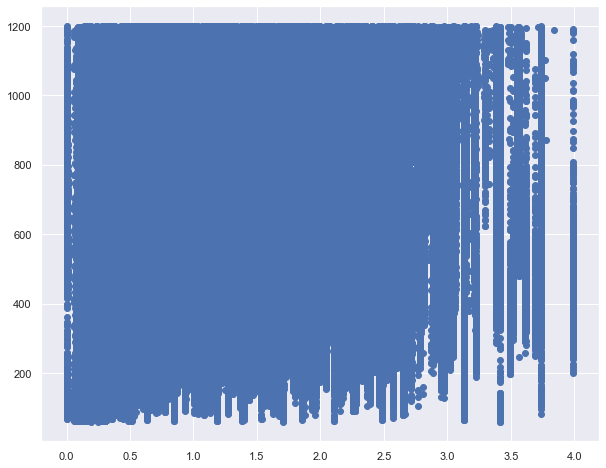

In [82]:
plt.scatter(df_dist['distance'], df_dist['duration_sec'])
plt.show()

Based on this initial scatter, there doesn't appear to be a good relationship between miles traveled and the duration. There are other factors influencing the trip duration. For the sake of de-obfuscating the many data points, plot a hexbin to get a sense of the hot areas of the distribution.

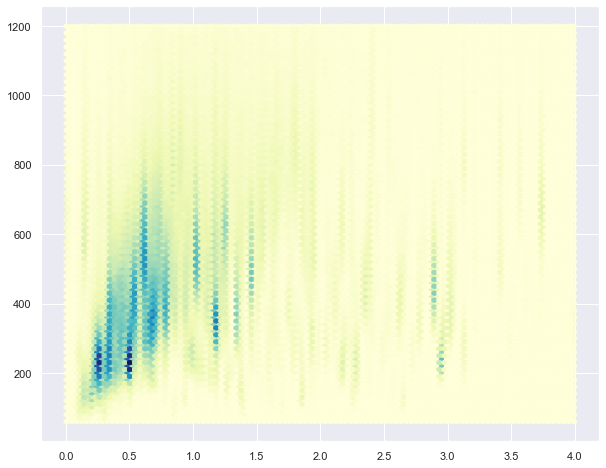

In [86]:
plt.hexbin(df_dist['distance'], df_dist['duration_sec'], cmap='YlGnBu')
plt.show()

Although this chart does show a heatmap reflecting the initial hypothesis, there isn't a good way to obtain a good regression model between trip length and duration based on the low correlation. Any number of factors could influence this analysis such as if the rider is a tourist or regular inhabitant, purpose of the trip (e.g. grocery store, sightseeing, commute, general recreation, etc), or other factors.

The data could also be further cleansed for the missing data between 2016-2017 and age outliers. Gender was also missing for a large number of data points.

However the salient insights gained include a large adoption of ridesharing tech in recent years (wider availability, larger demand, reduced cost) and the important stations that see an outsized portion of the demand and could be allocated more bicycles than the current capacities.